In [1]:
import sys
sys.path.append("..")
import math
import torch
from torch import tensor
import parts
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output, display, update_display

# Trying learning using temporal difference:
Sep 9, 2025

In [2]:
class Layer(parts.Layer): # adds learning
	def __init__(self, shape):
		super().__init__(shape)
		self.learnp = torch.zeros(shape)
		self.learnd = torch.zeros(shape)
	def learn(self, lr=0.1):
		self.learnp += (self.v-self.learnp)/8
		self.learnd += (self.learnp-self.learnd)/8
		error = self.learnp-self.learnd
		for sender in self.w:
			self.w[sender] += error[None,:] * sender.v[:,None] * lr
			self.w[sender].clamp_(0.0,1.0)

In [4]:
# test learning
torch.manual_seed(0)
patterns=[(torch.rand((10,)) < 0.2).type(torch.float) for _ in range(5)]

layer1 = Layer(10)
layer2 = Layer(10)

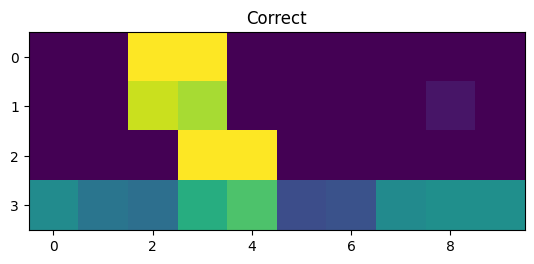

In [7]:
# test learning
disp=display(display_id=True)
for _ in range(10):
	p = patterns[random.randint(0,len(patterns)-1)]
	layer1.v.zero_()
	layer2.v.zero_()
	for i in range(10):
		layer1.inputTensor(p)
		layer2.input(layer1)
		layer1.update()
		layer1.learn()
		layer2.update()
		layer2.learn()
		plt.imshow([p,layer1.v,layer2.v,layer2.learnp-layer2.learnd+0.5], vmin=0,vmax=1)
		clear_output(True)
		plt.title("Predict")
		disp.update(plt.figure)
		plt.pause(0.1)

	for i in range(10):
		layer1.inputTensor(p)
		layer2.input(layer1)
		layer1.update()
		layer1.learn()
		layer2.update()
		layer2.v.copy_(p.roll(1))
		layer2.learn()
		plt.imshow([p,layer1.v,layer2.v,layer2.learnp-layer2.learnd+0.5], vmin=0,vmax=1)
		clear_output(True)
		plt.title("Correct")
		disp.update(plt.figure)
		plt.pause(0.1)

In [ ]:
class PredictingLayer(Layer):
	def __init__(self, shape):
		super().__init__(shape)
		self.prevSenderV = {}
	def input(self, sender):
		if not sender in self.w:
			self.w[sender] = parts.initWeights((sender.shape,self.shape))
			self.prevSenderV[sender] = torch.zeros(sender.shape)
		self.inputExcitatory += self.prevSenderV[sender] @ self.w[sender]
	def update(self, alphaCycleProgess, layerToPredict):
		super().updateV()
		if alphaCycleProgess > 0.5:
			self.v.copy_(layerToPredict)
	def updatePostAlphaCycle(self):
		for sender in self.w:
			self.prevSenderV[sender] = sender.v.clone()
	

# Sep 10, 2025

In [2]:
class Layer(parts.Layer):
	def learn(self, alphaCycleProgress):
		if alphaCycleProgress["minusPhaseEnd"]:
			self.vMinusPhase = self.v.clone()
		if alphaCycleProgress["end"]:
			for sender in self.w:
				self.w[sender] += (self.v-self.vMinusPhase)[None,:] * sender.v[:,None] * 0.1
				self.w[sender].clamp_(0.0,1.0)

class DeeppredLayers:
	def __init__(self, shape):
		self.s = Layer(shape) # superficial
		self.p = {} # predicting layers / pulvinar
		self.c = Layer(shape) # previous superficial layer activation / CT
		self.lowerLayers = set()
	def input(self, sender, *args, **kwargs):
		if not sender in self.lowerLayers:
			self.lowerLayers.add(sender)
		self.s.input(sender, *args, **kwargs)
		
	def update(self, alphaCycleProgress):
		self.c.update()
		for lowerLayer in self.lowerLayers:
			if not lowerLayer in self.p:
				self.p[lowerLayer] = Layer(lowerLayer.shape)

			#if not hasattr(lowerLayer,"vPrevAlphaCycle"):
			#	lowerLayer.vPrevAlphaCycle = torch.zeros(lowerLayer.shape)

			if alphaCycleProgress["plusPhase"]:
				self.p[lowerLayer].constantV = lowerLayer.v
			else:
				self.p[lowerLayer].constantV = None
				self.p[lowerLayer].input(self.c, bidirectional=False)

			self.p[lowerLayer].update()
			self.s.input(self.p[lowerLayer], bidirectional=False)

		self.s.update()
		
		if alphaCycleProgress["end"]:
			self.c.constantV = self.s.v
			#for lowerLayer in self.lowerLayers:
			#	lowerLayer.vPrevAlphaCycle.copy_(lowerLayer.v)

	def getLayers(self):
		yield self.s; yield from self.p.values(); yield self.c

In [3]:
patterns=torch.diagonal_scatter(torch.zeros(5,10),torch.ones(5))

inputLayer = Layer(10)
d1 = DeeppredLayers(10)
disp=display(display_id=True)

<function matplotlib.pyplot.figure(num: 'int | str | Figure | SubFigure | None' = None, figsize: 'ArrayLike | None' = None, dpi: 'float | None' = None, *, facecolor: 'ColorType | None' = None, edgecolor: 'ColorType | None' = None, frameon: 'bool' = True, FigureClass: 'type[Figure]' = <class 'matplotlib.figure.Figure'>, clear: 'bool' = False, **kwargs) -> 'Figure'>

In [ ]:
def update(pattern, alphaCycleProgress):
	inputLayer.constantV = pattern
	inputLayer.update()
	d1.input(inputLayer)
	d1.update(alphaCycleProgress=alphaCycleProgress)
	
	for layer in d1.getLayers():
		layer.learn(alphaCycleProgress=alphaCycleProgress)

	plt.imshow([inputLayer.v, d1.s.v, d1.c.v, d1.p[inputLayer].v], vmin=0,vmax=1)
	clear_output(True)
	disp.update(plt.figure)
	plt.pause(0.02)

for i in range(10):
	for pattern in patterns:
		for i in range(10):
			plt.title("Predict "+str(i))
			update(pattern, {"plusPhase":False, "end":False, "minusPhaseEnd":i==9})
		for i in range(10):
			plt.title("Correct "+str(i))
			update(pattern, {"plusPhase":True, "end":i==9, "minusPhaseEnd":False})